<h1>¿Cuál es la historia que describe mejor proporción para el pronóstico de plantas?</h1>

In [1]:
import modulo_conn_sql as mcq
import numpy as np
import pandas as pd 
import datetime 
import matplotlib.pyplot as plt
from pandas.tseries.offsets import MonthEnd
from pandas.tseries.offsets import MonthBegin

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def conectarSQL():
    conn = mcq.ConexionSQL()
    cursor = conn.getCursor()
    return cursor

#Query BD SQL-Server Cemex
def querySQL(query, parametros):
    #Conectar con base sql y ejecutar consulta
    cursor = conectarSQL()
    try:
        cursor.execute(query, parametros)
        #obtener nombre de columnas
        names = [ x[0] for x in cursor.description]
        
        #Reunir todos los resultado en rows
        rows = cursor.fetchall()
        resultadoSQL = []
            
        #Hacer un array con los resultados
        while rows:
            resultadoSQL.append(rows)
            if cursor.nextset():
                rows = cursor.fetchall()
            else:
                rows = None
                
        #Redimensionar el array para que quede en dos dimensiones
        resultadoSQL = np.array(resultadoSQL)
        resultadoSQL = np.reshape(resultadoSQL, (resultadoSQL.shape[1], resultadoSQL.shape[2]) )
    finally:
            if cursor is not None:
                cursor.close()
    return pd.DataFrame(resultadoSQL, columns = names)
 
# dataset(pandas dataframe): base de datos con el historico
# array_group_top(array) : array de la jerarquia mas ALTA con el nombre de las columnas del dataset por el cual se quiere agrupar las proporciones
# array_group_bottom(array) : array de la jerarquia mas BAJA con el nombre de las columnas del dataset por el cual se quiere agrupar las proporciones
# medida_target( string ) : nombre de la columna que contiene los datos objetivo de la proporcion
# group_target(array) : array de nombre de columnas con las cuales queremos la proporcion final
# name_proportion(string) : etiqueta de la dimension a la cual le estamos calculando la proporcion
    
def historical_proportion( dataset, array_group_top, array_group_bottom, medida_target, group_target, name_proportion  ):

    promedio_group_top = dataset.groupby(array_group_top)[medida_target].mean().reset_index()
    promedio_group_bottom = dataset.groupby(array_group_bottom)[medida_target].mean().reset_index()    
    proportion  = pd.merge(promedio_group_bottom, promedio_group_top, how = 'inner', left_on = array_group_top, right_on = array_group_top )
    proportion['proportion'] = proportion[medida_target + '_x'] / proportion[medida_target + '_y']
    proportion = proportion.groupby(group_target)['proportion'].mean().reset_index()
    proportion.rename(columns={'proportion':'proportion_' + name_proportion}, inplace = True)
    
    return proportion 

def forecast_planta (DesagregacionPronosticoPlanta, volPais):
    proportion_plant = historical_proportion(DesagregacionPronosticoPlanta, ['Año', 'Mes'], ['Año', 'Mes', 'Planta'], 'totalEntregado', ['Planta'], 'planta')
    DesagregacionPronosticoPlanta = pd.DataFrame({'Planta' : DesagregacionPronosticoPlanta["Planta"].unique()})
    #se divide el volumen por igual en cada planta
    DesagregacionPronosticoPlanta['M3ForecastPlanta'] = volPais / DesagregacionPronosticoPlanta['Planta'].count()
    
    #join con proporcion planta
    DesagregacionPronosticoPlanta = pd.merge(DesagregacionPronosticoPlanta, proportion_plant, how='left', left_on=['Planta'], right_on=['Planta'] ).fillna(1)
    
    #se itera con las proporciones y se ajusta el resultado hasta que el gap sea menor a 1
    gap_iteracion = 1000.0
    while( abs(gap_iteracion) > 1 ):
        DesagregacionPronosticoPlanta['forecast_planta'] =  DesagregacionPronosticoPlanta['M3ForecastPlanta'] * DesagregacionPronosticoPlanta['proportion_planta'] 
        resultado_iteracion = DesagregacionPronosticoPlanta['forecast_planta'].sum()
        gap_iteracion = resultado_iteracion - volPais
        DesagregacionPronosticoPlanta['M3ForecastPlanta'] = DesagregacionPronosticoPlanta['M3ForecastPlanta'] - (gap_iteracion / DesagregacionPronosticoPlanta['Planta'].count() )
    DesagregacionPronosticoPlanta = DesagregacionPronosticoPlanta[['Planta','forecast_planta']]
    
    return DesagregacionPronosticoPlanta


In [41]:
#años para entrenar las versiones
yearDesagregacion = 2021
mesDesagregacion = 2

#Targets
pais = 'Guatemala'    
volPais = 5753
inicioHistoria = datetime.datetime(2015, 1, 1) #'2013-05-01'
finHistoria = datetime.datetime(2021, 4 , 21)

criterio_historia_reciente = 3 #meses

In [42]:
#Consulta de datos en la base SQL
despachosSQL = querySQL(  "{CALL SCAC_AP8_BaseForecast (?,?,?)}", (pais, inicioHistoria.strftime("%Y-%m-%d"), finHistoria.strftime("%Y-%m-%d") ) )
#arreglo de formatos
despachosSQL['totalEntregado'] = despachosSQL['totalEntregado'].astype(float)

In [43]:
#dataframe con el real de cada planta por mes
df_plantas = despachosSQL.groupby(['Año','Mes', 'Planta'])['totalEntregado'].sum().reset_index()
df_plantas.rename(columns={'totalEntregado':'Real'}, inplace = True)

In [44]:
df_plantas

,Año,Mes,Planta,Real
0,2015,1,G751,49.5
1,2015,1,G752,2705.5
2,2015,1,G753,452.5
3,2015,1,G755,1261.0
4,2015,1,G758,1383.5
...,...,...,...,...
214,2021,2,G753,271.0
215,2021,3,G752,5241.5
216,2021,3,G753,140.0
217,2021,4,G752,2930.5


In [45]:
def encontar_mejor_historia(yearTarget, meses_historia, df_plantas ):
    mejores_versiones_mes = pd.DataFrame()
    #ciclo por j meses del año target
    for j in range(0, 12):
        mesTarget = j + 1
        #tabla pivot para tener el volumen real por planta por mes
        pivot = df_plantas[(df_plantas['Año'] == yearTarget) & (df_plantas['Mes'] == mesTarget)]
        #volumen total real entregado en el mes target
        volTarget = df_plantas[(df_plantas['Año'] == yearTarget) & (df_plantas['Mes'] == mesTarget)]['Real'].sum()
        #ciclo a traves de la historia hacia atras para analisar las proporciones resultantes a medida que aumenta la historia
        for i in range(0,meses_historia):
            historia = datetime.datetime(yearTarget, mesTarget, 1)  - MonthBegin(i + 1)
            test = forecast_planta(despachosSQL[(despachosSQL['FechaEntrega'] < datetime.datetime(yearTarget, mesTarget, 1)) & (despachosSQL['FechaEntrega'] >= historia)], volTarget )
            #test['version'] = 'version_' + str(i+1) 
            test['version'] = i+1
            pivot_temp = pd.merge(pivot, test, on=['Planta'])

            if i == 0:
                planta_versiones = pivot_temp
            else:
                planta_versiones = pd.concat([planta_versiones, pivot_temp])

        #Error porcentual absoluto ponderado por el volumen de cada planta
        planta_versiones['APE_ponderado'] = ((((planta_versiones['Real'] - planta_versiones['forecast_planta']) / planta_versiones['Real']).abs()) * planta_versiones['Real']) / volTarget
        #Promedio del APE ponderado de cada planta
        #planta_versiones = planta_versiones.groupby(['Año','Mes','version'])['APE_ponderado'].mean().reset_index()
        planta_versiones = planta_versiones.groupby(['Año','Mes','version'])['APE_ponderado'].sum().reset_index()
        #Obtengo la version con menor promedio de APE
        planta_versiones = planta_versiones.loc[planta_versiones.groupby(['Año','Mes'])['APE_ponderado'].idxmin()]
        if j == 0:
            mejores_versiones_mes = planta_versiones
        else:
            mejores_versiones_mes = pd.concat([mejores_versiones_mes, planta_versiones])
        
    return mejores_versiones_mes

In [46]:
for k in range(2016, 2020):
    if k == 2016:
        resultado = encontar_mejor_historia(k, 6, df_plantas)
    else:
        temp =  encontar_mejor_historia(k, 6, df_plantas)
        resultado = pd.concat([resultado, temp])

In [47]:
resultado

,Año,Mes,version,APE_ponderado
2,2016,1,3,0.272683
0,2016,2,1,0.090924
5,2016,3,6,0.273085
0,2016,4,1,0.212251
3,2016,5,4,0.076773
1,2016,6,2,0.033155
5,2016,7,6,0.173697
0,2016,8,1,0.005284
1,2016,9,2,0.152761
5,2016,10,6,0.115657


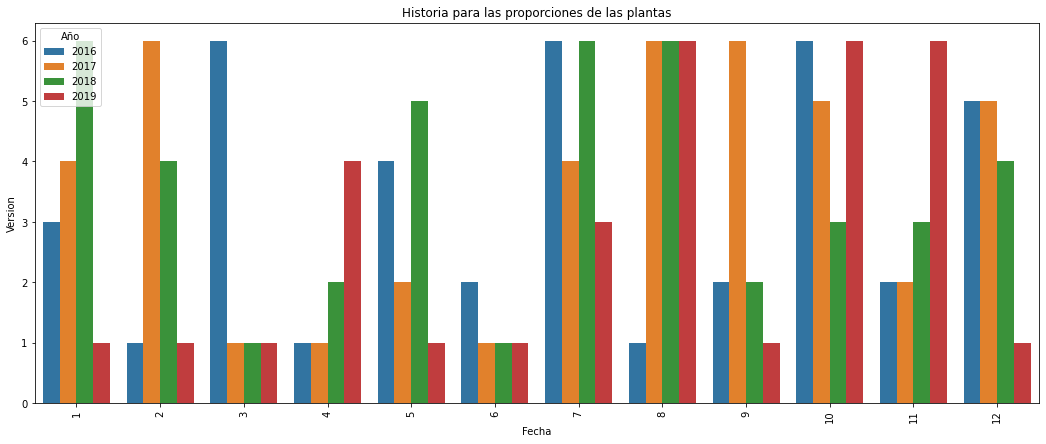

In [48]:
plt.figure(figsize=(18,7))

sns.barplot(x = resultado['Mes'], 
            y = resultado['version'], 
            data = resultado,
            hue = 'Año')
            
plt.xlabel("Fecha")
plt.ylabel("Version")
plt.title("Historia para las proporciones de las plantas")
plt.xticks(rotation=90)
plt.show()

In [23]:
plt.figure(figsize=(18,7))
sns.boxplot(x='version', y = 'APE_ponderado', data = planta_versiones, showmeans=True)
plt.xticks(rotation=90)

NameError: name 'planta_versiones' is not defined

<Figure size 1296x504 with 0 Axes>

In [104]:
planta_versiones[planta_versiones['version']=='version_3']

,Año,Mes,Planta,Real,forecast_planta,version,APE_ponderado
0,2021,1,F001,9400.50,8097.280019,version_3,0.013894
1,2021,1,F003,4176.75,5164.458149,version_3,0.010530
2,2021,1,F006,3594.00,3679.695040,version_3,0.000914
3,2021,1,F007,7722.00,6783.442090,version_3,0.010006
4,2021,1,F009,4384.25,3728.690388,version_3,0.006989
5,2021,1,F010,4298.50,3533.289389,version_3,0.008158
6,2021,1,F011,4468.00,3744.507323,version_3,0.007713
7,2021,1,F012,1857.75,2672.820054,version_3,0.008690
8,2021,1,F014,3711.25,3888.151705,version_3,0.001886
9,2021,1,F015,1082.00,1500.315991,version_3,0.004460
